# Hierarchical Clustering, PCA, Log Regres - 26-June-2017
----------------------------
## Summary
1. Hierarchical Clustering 
2. PCA
3. Log Regressions_ ROC Curves
----------------------------

#### Imports 

In [1]:
%matplotlib inline
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import neighbors

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

from __future__ import division

#### Helper functions

In [2]:
# get data from the data file
def get_data(data_dict, data_id):
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    data = df.iloc[:,1:]
    target = df.fall
    return data_name, data, target

#gets data for a specific activity
def get_data_by_activity(data_dict, data_id, test_dict, activity_id):
    # read in data
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    # join with activity data 
    df = df.join(test_dict[['activity_id']])
    # select required activity and all falls
    data = df[ (df.activity_id == activity_id) | df.fall == 1]
    # get data and target 
    target = data['fall']
    data = data.drop(['fall','activity_id'], axis = 1)
    # get activity name
    dd = test_dict[test_dict.activity_id == activity_id].head(1)
    activity_name = dd.iloc[0,1]
    data_name = activity_name
    return data_name, data, target

# gets data with multiclass target
def get_data_multiclass(data_dict, data_id, test_dict):
    # read in data
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    # join with activity data 
    df = df.join(test_dict[['activity_id']])
    # for all falls ( i.e. with activity_id > = 9) set activity_id = 9 as a class label
    df.loc[df.activity_id > 9,'activity_id'] = 9
    # get data and target 
    target = df['activity_id']
    data = df.drop(['fall','activity_id'], axis = 1)
    return data_name, data, target

# normalises train data set as (X - mean / stdev) and applies the same scaling to test dataset 
def train_test_normalise(x_train, x_test):
    mean = x_train.mean().T
    std = x_train.std().T
    return ((x_train - mean)/std,(x_test - mean)/std) 

# returns model metrics for training and test sets
def model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='', data_name='', data_kind = '', info=''):
    #accuracy, probability of detection, probability of false alarm 
    train_accuracy, train_pod, train_pfa  = model_metrics_new(y_train, clf.predict(X_train))
    test_accuracy, test_pod, test_pfa  = model_metrics_new(y_test, clf.predict(X_test))
    # Area under the curve
    fpr, tpr, _ = metrics.roc_curve(y_train, clf.decision_function(X_train))
    train_auc = metrics.auc(fpr, tpr)
    fpr, tpr, _ = metrics.roc_curve(y_test, clf.decision_function(X_test))
    test_auc = metrics.auc(fpr, tpr)
       
    result = pd.DataFrame({'classifier': clf_name,
                           'data_set': data_name,
                           'data_kind':data_kind, 
                           'info': info,
                           'train_accuracy': train_accuracy, 
                           'train_PoD': train_pod, 
                           'train_PFA': train_pfa,
                           'train_AUC': train_auc,
                           'test_accuracy': test_accuracy, 
                           'test_PoD': test_pod, 
                           'test_PFA': test_pfa,
                           'test_AUC': test_auc
                          },
                          index = [0])
    columns = ['classifier','data_set','data_kind', 'test_accuracy', 'test_PoD', 'test_PFA', 'test_AUC',
              'train_accuracy', 'train_PoD', 'train_PFA', 'train_AUC', 'info']
    result = result[columns]
    return result

def model_metrics_new(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    TN = cm[0,0]
    FN = cm[1,0]
    TP = cm[1,1]
    FP = cm[0,1]
    accuracy = (TN + TP)/(TN + FP + FN + TP) 
    prob_detect = TP / (TP + FN)
    prob_false_alarm = FP /(TN + FP)
    return accuracy, prob_detect, prob_false_alarm


In [3]:
def remove_running_jumping(data,target,test_dict):

    data_new = data.copy(deep = True)
    target_new = target.copy(deep = True)
    
    data_new = data_new.join(test_dict[['activity']])
    data_new = data_new[(data_new.activity != 'jumping') & (data_new.activity != 'running')]
    data_new = data_new.drop('activity',axis=1)
    
    target_new = pd.DataFrame(target_new)
    target_new = target_new.join(test_dict[['activity']])
    target_new = target_new[(target_new.activity != 'jumping') & (target_new.activity != 'running')]
    target_new = target_new['fall']
    
    return data_new, target_new

#### Read in data dictionary for available datasets

In [4]:
data_dict = pd.read_csv('data/data_dict.csv', index_col = 0)
data_dict

,name,desc,num_features,file,normalise
id,,,,,
1,Magnitude_Stats,Summary statistics for the time series of acc...,8,data/magn_stats.csv,1
2,TriaxAccel_Stats,Summary statistics for triaxial acceleration,24,data/triax_stats.csv,1
3,Magnitude_Timeseries,Time series of acceleration magnitude,51,data/magn_ts.csv,0
4,TriaxAccel_Timeseries,Time series of triaxial accelaration - raw data,153,data/triax_ts.csv,0


In [5]:
test_dict = pd.read_csv('data/test_dict.csv', index_col = 0)
test_dict['subtype'].value_counts()

FALL            1699
running         1673
walking         1021
going_down       707
going_up         651
jumping          445
lying_down       260
getting_up       218
sitting_down     180
standing_up      159
Name: subtype, dtype: int64

In [6]:
# read activities dictionary
activity_dict = pd.read_csv('data/activity_dict.csv', index_col = 0)
# get class names
class_names = np.array(activity_dict.iloc[:,:]['activity'])
class_names

array(['standing_up', 'getting_up', 'walking', 'running', 'going_up',
       'jumping', 'going_down', 'lying_down', 'sitting_down',
       'falling_forward', 'falling_right', 'falling_back',
       'falling_obstacle', 'falling_protection', 'falling_chair',
       'falling_syncope', 'falling_left'], dtype=object)

---------------------
## Hierarchical Clustering

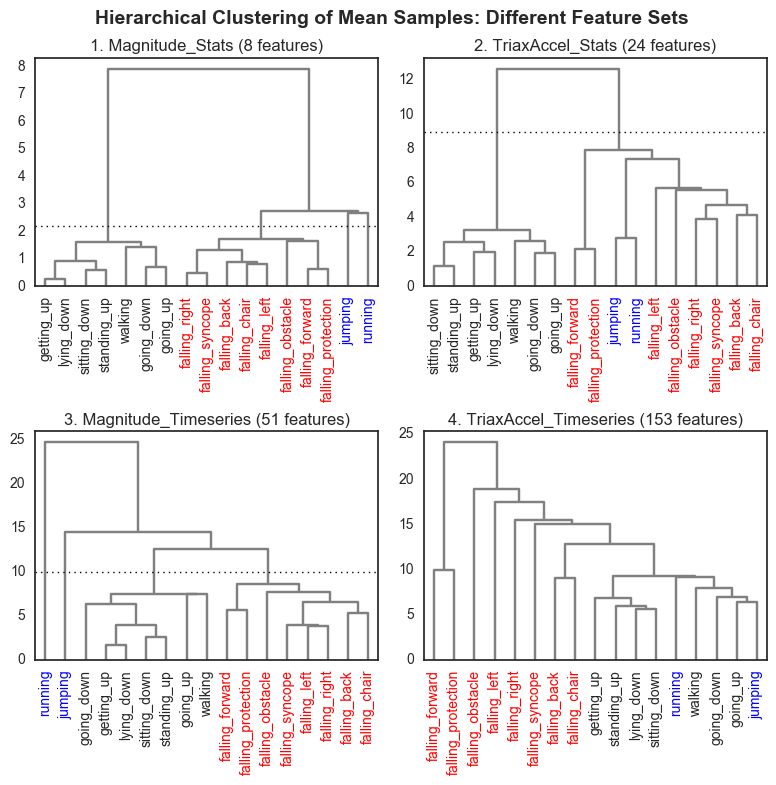

In [7]:
sns.set_style('white')
g,ax = plt.subplots(2,2, figsize = (8,8))
ax = ax.flatten()
cutoff_dist = [2.2,9,10,100]
count_plot = 0
for data_id in range(1,5):
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    num_features = data_dict.get_value(data_id, 'num_features')
    df = pd.read_csv(file_name, index_col = 0)
    df = df.join(test_dict[['activity','type']])
    df = df.drop('fall',axis = 1)
    data_means = df.groupby(by = 'activity').mean()
    Z = hierarchy.linkage(data_means, 'single')
  
    dn = hierarchy.dendrogram(Z,ax =ax[count_plot], labels = data_means.index, 
                            leaf_rotation = 90, leaf_font_size=10,link_color_func=lambda k: 'grey')
    
    title = '%d. %s (%d features)' %(data_id, data_name,num_features)
    ax[count_plot].set_title(title)
    ax[count_plot].set_ylabel = 'distance' 
    # colour  code labels in red
    for i in ax[count_plot].get_xticklabels():
        activity_name = i.get_text() 
        if activity_name.startswith('falling'):
            i.set_color('red')
        elif activity_name in ('running','jumping'):
            i.set_color('blue')
    # draw horizontal lines for cluster cutoffs        
    ax[count_plot].axhline(cutoff_dist[count_plot],linewidth=1, linestyle=':', color = 'black')
    count_plot +=1
#decorate plot
plt.tight_layout()    
plt.subplots_adjust(top = 0.92)
plt.suptitle('Hierarchical Clustering of Mean Samples: Different Feature Sets', fontsize = 14, fontweight = 'bold');
plt.savefig('plots/dendogram.png')

-------------
## Principal components - separability of categories

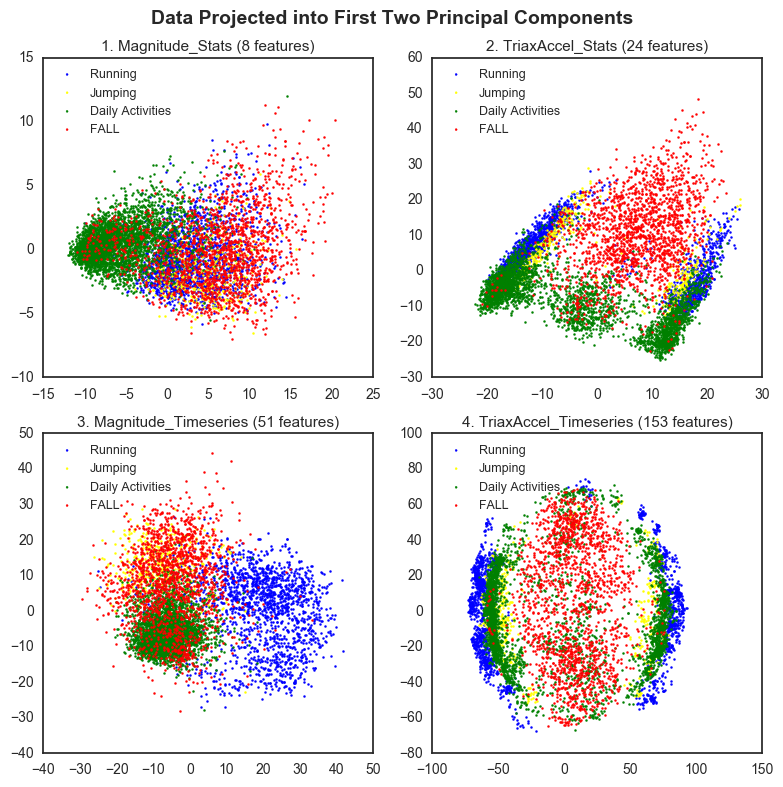

In [8]:
g,ax = plt.subplots(2,2, figsize = (8,8))
ax = ax.flatten()
count_plots = 0
for data_id in range(1,5):
    data_name, data, target = get_data(data_dict,data_id = data_id)
    num_features = data_dict.get_value(data_id, 'num_features')
    #do PCA
    pca = PCA(n_components=2)
    data_pc = pd.DataFrame(pca.fit_transform(data), columns = ['PC1','PC2'])
    data_pc = data_pc.join(test_dict[['category']])
    # plot results by category
   
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='Running','PC1'], 
                            y = data_pc.loc[data_pc.category=='Running','PC2'], 
                            label = 'Running', c = 'blue', s = 2, edgecolors = 'face')
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='Jumping','PC1'], 
                            y = data_pc.loc[data_pc.category=='Jumping','PC2'], 
                            label ='Jumping', c = 'yellow', s = 2 , edgecolors = 'face')
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='ADL','PC1'], 
                            y = data_pc.loc[data_pc.category=='ADL','PC2'], 
                            label = 'Daily Activities', c = 'green', s = 2,edgecolors = 'face')
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='FALL','PC1'], 
                            y = data_pc.loc[data_pc.category=='FALL','PC2'], 
                            label = 'FALL',c = 'red', s = 2 , edgecolors = 'face')
    
    ax[count_plots].set_title ( '%d. %s (%d features)' %(data_id, data_name,num_features), fontsize = 11)
    ax[count_plots].legend(loc='upper left', fontsize = 9)
    count_plots +=1
    
plt.tight_layout()    
plt.subplots_adjust(top = 0.92)
plt.suptitle('Data Projected into First Two Principal Components', fontsize = 14, fontweight = 'bold');
plt.savefig('plots/PCA_Scatter.png')    

## Logistic Regressions - ROC curves 

In [9]:
# regularisation params
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
param_grid = {'C': Cs, 'penalty':['l1','l2']}

1 Magnitude_Stats
All data 01:07:47
Exc jump,run 01:07:49
Rebalanced 01:07:50
2 TriaxAccel_Stats
All data 01:07:51
Exc jump,run 01:07:54
Rebalanced 01:07:56
3 Magnitude_Timeseries
All data 01:07:58
Exc jump,run 01:08:25
Rebalanced 01:08:52
4 TriaxAccel_Timeseries
All data 01:09:27
Exc jump,run 01:12:00
Rebalanced 01:14:04


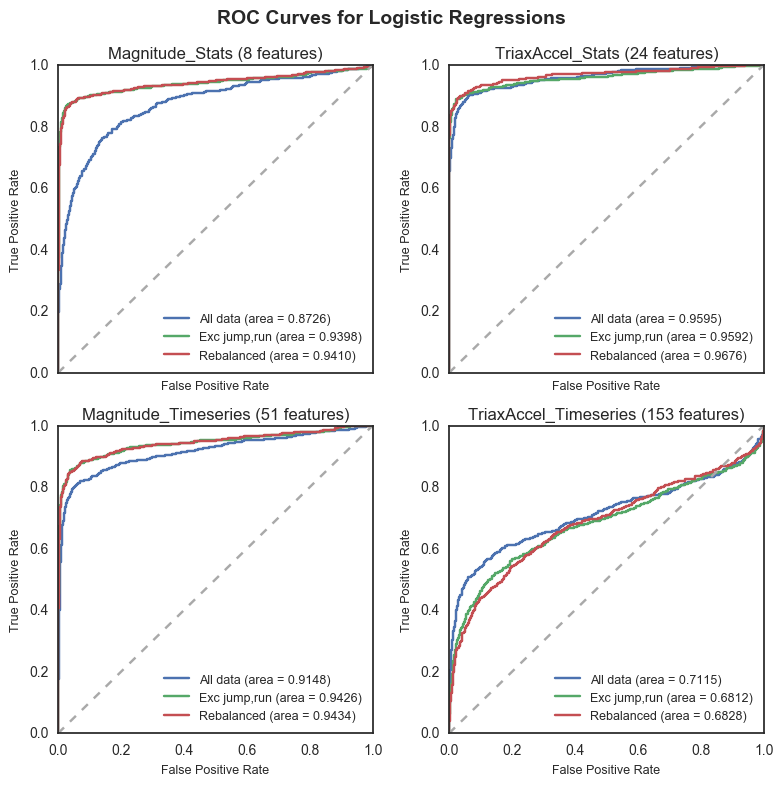

In [10]:
from datetime import datetime

g,ax = plt.subplots(2,2, figsize = (8,8), sharex=True)
ax = ax.flatten()
count_plots = 0

res_store = pd.DataFrame()
for data_id in [1,2,3,4]:
    #get data
    data_name, data, target = get_data(data_dict,data_id)
    print data_id, data_name
    num_features = data_dict.get_value(data_id, 'num_features')
    data_desc = '%s (%d features)' %(data_name, num_features)
    need_normalise = data_dict.get_value(data_id,'normalise') 
    
    #--- train classifier on the data as it is (unbalanced)---------------- 
    data_kind = 'All data'
    print data_kind, datetime.now().strftime('%H:%M:%S')
    #split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): X_train, X_test = train_test_normalise(X_train, X_test)
    #train classifier
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)    
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr',data_name=data_desc,
                          data_kind = data_kind, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    #  plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, clf.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    ax[count_plots].plot(fpr, tpr, label= '%s (area = %0.4f)' %(data_kind,roc_auc))    
    
    #---remove running and jumping and train again------------------------
    data_kind = 'Exc jump,run'
    print data_kind, datetime.now().strftime('%H:%M:%S')
    data, target = remove_running_jumping (data, target, test_dict)
       
    #split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): X_train, X_test = train_test_normalise(X_train, X_test)
    #train classifier
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)    
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr',data_name=data_desc,
                          data_kind = data_kind, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    #  plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, clf.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    ax[count_plots].plot(fpr, tpr, label= '%s (area = %0.4f)' %(data_kind,roc_auc)) 
    
    #---duplicate falls to balance the data--------------------------------
    data_kind = 'Rebalanced'
    print data_kind, datetime.now().strftime('%H:%M:%S')
    # append falls data 
    X_train = X_train.append(X_train[y_train== 1])
    y_train = y_train.append(y_train[y_train== 1])
    #train classifier
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)    
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr',data_name=data_desc,
                          data_kind = data_kind, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    #  plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, clf.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    ax[count_plots].plot(fpr, tpr, label= '%s (area = %0.4f)' %(data_kind,roc_auc))
    
    # decorate plot
    ax[count_plots].plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
    ax[count_plots].set_xlim([0.0, 1.0])
    ax[count_plots].set_ylim([0.0, 1.0])
    ax[count_plots].set_xlabel('False Positive Rate', fontsize=9)
    ax[count_plots].set_ylabel('True Positive Rate', fontsize=9)
    ax[count_plots].set_title(data_desc)
    ax[count_plots].legend(loc="lower right", fontsize=9); 
    count_plots += 1

plt.tight_layout()    
plt.subplots_adjust(top = 0.91)
plt.suptitle('ROC Curves for Logistic Regressions', fontsize = 14, fontweight = 'bold');
plt.savefig('plots/Roc_Curves.png')     


In [11]:
res_store.to_csv('out/LogRegr_Results.csv')
res_store

,classifier,data_set,data_kind,test_accuracy,test_PoD,test_PFA,test_AUC,train_accuracy,train_PoD,train_PFA,train_AUC,info
0,LogRegr,Magnitude_Stats (8 features),All data,0.858874,0.604651,0.058546,0.872627,0.872593,0.633037,0.051627,0.888235,"{'penalty': 'l1', 'C': 0.1}"
0,LogRegr,Magnitude_Stats (8 features),"Exc jump,run",0.935138,0.874622,0.033951,0.939850,0.921689,0.856316,0.042632,0.941486,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,Magnitude_Stats (8 features),Rebalanced,0.914198,0.894260,0.075617,0.941027,0.906392,0.893925,0.080000,0.942586,"{'penalty': 'l1', 'C': 0.1}"
0,LogRegr,TriaxAccel_Stats (24 features),All data,0.942979,0.840116,0.023607,0.959545,0.956026,0.871414,0.017209,0.971489,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,TriaxAccel_Stats (24 features),"Exc jump,run",0.938713,0.892749,0.037809,0.959202,0.947225,0.900675,0.027368,0.964310,"{'penalty': 'l1', 'C': 0.01}"
0,LogRegr,TriaxAccel_Stats (24 features),Rebalanced,0.932074,0.907855,0.055556,0.967603,0.938098,0.923819,0.046316,0.975109,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,Magnitude_Timeseries (51 features),All data,0.919102,0.765988,0.031161,0.914820,0.924887,0.774481,0.027534,0.930785,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,Magnitude_Timeseries (51 features),"Exc jump,run",0.922880,0.838369,0.033951,0.942604,0.922370,0.846673,0.036316,0.948343,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,Magnitude_Timeseries (51 features),Rebalanced,0.911134,0.871601,0.068673,0.943430,0.905385,0.882353,0.069474,0.949960,"{'penalty': 'l2', 'C': 10}"
0,LogRegr,TriaxAccel_Timeseries (153 features),All data,0.826443,0.341570,0.016053,0.711549,0.832660,0.346192,0.013454,0.721130,"{'penalty': 'l1', 'C': 0.01}"


1 Magnitude_Stats 01:16:10
Rebalanced 01:16:10
2 TriaxAccel_Stats 01:16:12
Rebalanced 01:16:12
3 Magnitude_Timeseries 01:16:14
Rebalanced 01:16:14


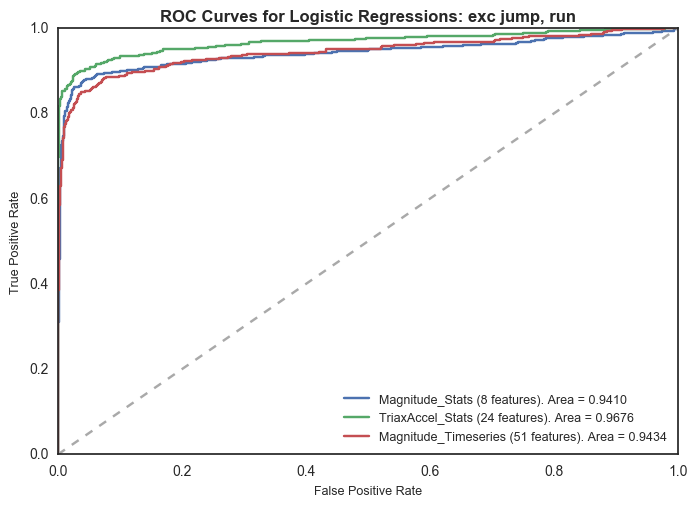

In [12]:
res_store = pd.DataFrame()
for data_id in [1,2,3]:
    #get data
    data_name, data, target = get_data(data_dict,data_id)
    print data_id, data_name, datetime.now().strftime('%H:%M:%S')
    num_features = data_dict.get_value(data_id, 'num_features')
    data_desc = '%s (%d features)' %(data_name, num_features)
    need_normalise = data_dict.get_value(data_id,'normalise') 
        
    #remove running and jumping and train again------------------------
    data, target = remove_running_jumping (data, target, test_dict)
       
    # split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): X_train, X_test = train_test_normalise(X_train, X_test)
    
    # duplicate falls to balance the data
    print data_kind, datetime.now().strftime('%H:%M:%S')
    # append falls data 
    X_train = X_train.append(X_train[y_train== 1])
    y_train = y_train.append(y_train[y_train== 1])
    #train classifier
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)    
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr',data_name=data_desc,
                          data_kind = data_kind, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    #  plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, clf.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label= '%s. Area = %0.4f' %(data_desc,roc_auc))
    
    
# decorate plot
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curves for Logistic Regressions: exc jump, run', fontsize = 12, fontweight = 'bold')
plt.legend(loc="lower right", fontsize=9); 

plt.savefig('plots/Roc_Curves_SinglePlot.png')     

In [13]:
res_store.to_csv('out/LogRegr_Results_balanced.csv')
res_store

,classifier,data_set,data_kind,test_accuracy,test_PoD,test_PFA,test_AUC,train_accuracy,train_PoD,train_PFA,train_AUC,info
0,LogRegr,Magnitude_Stats (8 features),Rebalanced,0.914198,0.894260,0.075617,0.941021,0.906392,0.893925,0.080000,0.942582,"{'penalty': 'l1', 'C': 0.1}"
0,LogRegr,TriaxAccel_Stats (24 features),Rebalanced,0.932074,0.907855,0.055556,0.967596,0.938098,0.923819,0.046316,0.975111,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,Magnitude_Timeseries (51 features),Rebalanced,0.911134,0.871601,0.068673,0.943430,0.905385,0.882353,0.069474,0.949960,"{'penalty': 'l2', 'C': 10}"
